In [ ]:
!pip install tensorflow gymnasium[atari,accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 KB 21.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446676 sha256=fff27e35c4b86d3533a2cfcaf69d93b5bca0a21b14c2b72e473b2d28ba4ba17b
  Stored in directory: /root/.cache/pip/wheels/b1/1f/f7/2da07cf4f81ea264bdaf043028749d88fe0c2227134a22cf80
Successfully built AutoROM.accept-rom-license


In [ ]:
!pip install matplotlib
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import tensorflow as tf
from collections import deque
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow import keras

class better_dqn:
    def __init__(self,env,state_size, action_size):
        self.env = env
        self.epsilon = 1
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.005 
        self.gamma = 0.9
        self.replaymemorysize = 10000
        self.update_steps = 10
        self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.batchsize = 128
        self.iterations = 0
        self.model = self.dqn_model(state_size, action_size)
        self.target_model = self.dqn_model(state_size, action_size)
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
        self.loss_function = keras.losses.Huber()

    def dqn_model(self,state_size, action_size):
        
        return tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (5,5), input_shape = (state_size)),
            tf.keras.layers.MaxPooling2D((5,5)),
            tf.keras.layers.Conv2D(16, (5,5)),
            tf.keras.layers.MaxPooling2D((5,5)),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(action_size, activation='linear')
        ])
        # take action using the step function
    def act(self,state,state_size,train=True):
        if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = self.model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()
        else:
            action = self.env.action_space.sample()
        return action
    def store(self,state, action, reward, new_state, done):
        self.replaymemorybuffer.append([state, action, reward, new_state, done])
    def replay(self):
        if self.batchsize > len(self.replaymemorybuffer):
            return
        if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
            self.target_model.set_weights(self.model.get_weights())
        samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
        batchzip = zip(*samplebatch)
        state1, action, reward, state2 , termination = list(batchzip)
        done_sample = tf.convert_to_tensor(
                    [float(termination[i]) for i in range(len(termination))]
                )
        q_target = self.model.predict(np.array(state1), verbose=0)
        next_q_value = self.target_model.predict(np.array(state2), verbose=0)
        updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
        updated_q_values = updated_q_values * (1 - done_sample) - done_sample
        masks = tf.one_hot(action, self.action_space.n)

        with tf.GradientTape() as tape:
            # Train the model on the states and updated Q-values
            q_values = self.model(np.array(state1))

            # Apply the masks to the Q-values to get the Q-value for action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            # Calculate loss between new Q-value and old Q-value
            loss = self.loss_function(updated_q_values, q_action)

        # Backpropagation
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.iterations +=1
    def learn(self, num_episodes, episode_len):
        avg_reward = [0]
        epsilon_decay = []
        reward_per_epi = []
        for i in tqdm(range(num_episodes)):
            observation, info = self.env.reset()
            total_reward = 0
            for j in range(episode_len):
                action = self.act(observation, False)
                next_observation, reward,terminated, truncated, info = self.env.step(action)
                self.store(observation, action, reward, next_observation, terminated)
                # if j!= 0 and j%20==0:
                #   self.replay()
                total_reward += reward
                if terminated:
                    break
                observation = next_observation
            epsilon_decay.append(self.epsilon)
            self.replay()
            if i%10 == 0:
                self.save('atari_dqn_new.h5')
                tf.keras.backend.clear_session()
            self.epsilon *= self.epsilon_decay
            reward_per_epi.append(total_reward)
            avg_reward.append((avg_reward[-1]*len(avg_reward)+total_reward)/(len(avg_reward)+1))
        return epsilon_decay, reward_per_epi, avg_reward
    def load(self, name):
        self.model.load_weights(name)
        self.target_model.load_weights(name)
    def save(self, name):
        self.target_model.save_weights(name)

(210, 160, 3)


100%|██████████| 1000/1000 [1:52:22<00:00,  6.74s/it]


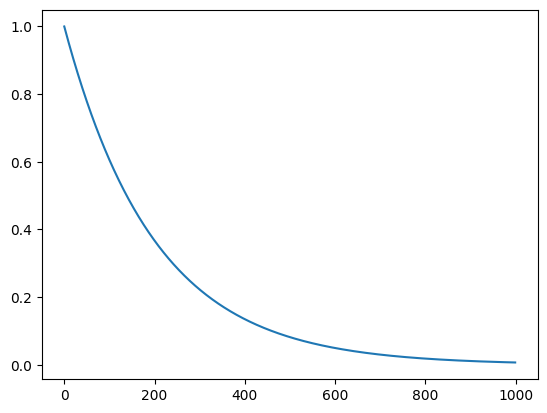

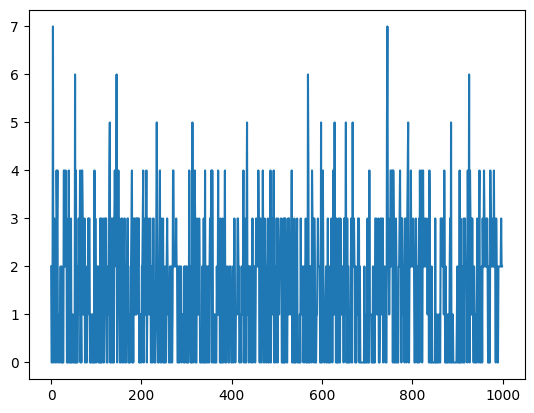

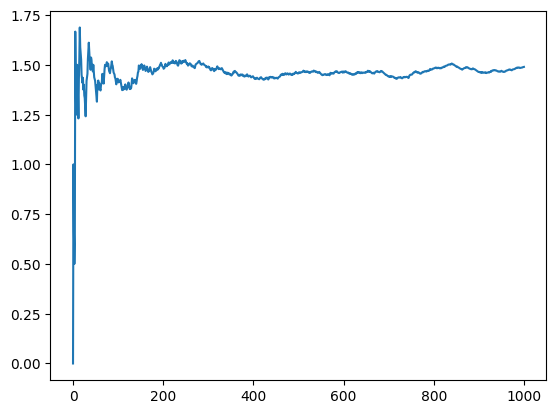

In [ ]:
env = gym.make('Breakout-v4')
print(env.observation_space.shape)
agent = better_dqn(env, env.observation_space.shape, env.action_space.n)
#agent.epsilon = 0.001
# agent.load('atari_dqn.h5')
epsilon_decay, reward_per_epi, avg_reward = agent.learn(1000,100000)


plt.plot(epsilon_decay)
plt.show()

plt.plot(reward_per_epi)
plt.show()

plt.plot(avg_reward)
plt.show()

In [ ]:
env = gym.make('Breakout-v4')
print(env.observation_space.shape)
agent = better_dqn(env, env.observation_space.shape, env.action_space.n)
#agent.epsilon = 0.001
# agent.load('atari_dqn.h5')
epsilon_decay, reward_per_epi, avg_reward = agent.learn(1000,100000)


plt.plot(epsilon_decay)
plt.show()

plt.plot(reward_per_epi)
plt.show()

plt.plot(avg_reward)
plt.show()

In [ ]:
from tensorflow import keras
class better_dqn:
  def __init__(self, env, state_size, action_size):
    self.env = env
    self.epsilon = 1
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.005 
    self.gamma = 0.9
    self.replaymemorysize = 10000
    self.update_steps = 10
    self.replaymemorybuffer = deque(maxlen = self.replaymemorysize)
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.batchsize = 128
    self.iterations = 0
    self.model = self.dqn_model(state_size, action_size)
    self.target_model = self.dqn_model(state_size, action_size)
    self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.loss_function = keras.losses.Huber()
  def dqn_model(self,state_size, action_size):
    input = tf.keras.layers.Input(shape=state_size)
    conv1 = tf.keras.layers.Conv2D(16, (5,5))(input)
    pool1 = tf.keras.layers.MaxPooling2D((5,5))(conv1)
    conv2 = tf.keras.layers.Conv2D(16, (5,5))(pool1)
    pool2 =  tf.keras.layers.MaxPooling2D((5,5))(conv2)
    flatten = tf.keras.layers.Flatten()(pool2)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
    value, advantage = tf.keras.layers.Dense(1,activation='linear')(dense2), tf.keras.layers.Dense(action_size,activation='linear')(dense2)
    q = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
    return tf.keras.models.Model(inputs=input, outputs=q)
  # take action using the step function
  def act(self,state,state_size,train=True):
    if not train or (np.random.uniform(self.epsilon_min,1)>=self.epsilon):
      state_tensor = tf.convert_to_tensor(state)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = self.model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
    else:
      action = self.env.action_space.sample()
    return action
  def store(self,state, action, reward, new_state, done):
    self.replaymemorybuffer.append([state, action, reward, new_state, done])
  def replay(self):
    if self.batchsize > len(self.replaymemorybuffer):
      return
    if self.iterations == 0 or (self.iterations%self.update_steps) == 0:
      self.target_model.set_weights(self.model.get_weights())
    samplebatch = random.sample(self.replaymemorybuffer, self.batchsize)
    batchzip = zip(*samplebatch)
    state1, action, reward, state2 , termination = list(batchzip)
    done_sample = tf.convert_to_tensor(
                [float(termination[i]) for i in range(len(termination))]
            )
    q_target = self.model.predict(np.array(state1), verbose=0)
    next_q_value = self.target_model.predict(np.array(state2), verbose=0)
    updated_q_values = reward + self.gamma * tf.reduce_max(next_q_value, axis=1)
    updated_q_values = updated_q_values * (1 - done_sample) - done_sample
    masks = tf.one_hot(action, self.action_space.n)

    with tf.GradientTape() as tape:
      # Train the model on the states and updated Q-values
      q_values = self.model(np.array(state1))

      # Apply the masks to the Q-values to get the Q-value for action taken
      q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
      # Calculate loss between new Q-value and old Q-value
      loss = self.loss_function(updated_q_values, q_action)

    # Backpropagation
    grads = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.iterations +=1
  def learn(self, num_episodes, episode_len):
    avg_reward = [0]
    epsilon_decay = []
    reward_per_epi = []
    for i in tqdm(range(num_episodes)):
      observation, info = self.env.reset()
      total_reward = 0
      for j in range(episode_len):
        action = self.act(observation, False)
        next_observation, reward,terminated, truncated, info = self.env.step(action)
        self.store(observation, action, reward, next_observation, terminated)
        # if j!= 0 and j%20==0:
        #   self.replay()
        total_reward += reward
        if terminated:
          break
        observation = next_observation
      epsilon_decay.append(self.epsilon)
      self.replay()
      if i%10 == 0:
        self.save('atari_dqn_new.h5')
        tf.keras.backend.clear_session()
      self.epsilon *= self.epsilon_decay
      reward_per_epi.append(total_reward)
      avg_reward.append((avg_reward[-1]*len(avg_reward)+total_reward)/(len(avg_reward)+1))
    return epsilon_decay, reward_per_epi, avg_reward
  def load(self, name):
    self.model.load_weights(name)
    self.target_model.load_weights(name)
  def save(self, name):
    self.target_model.save_weights(name)

(210, 160, 3)


100%|██████████| 10/10 [06:51<00:00, 41.11s/it]


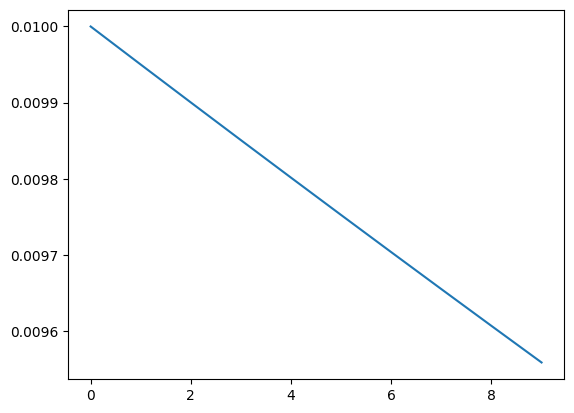

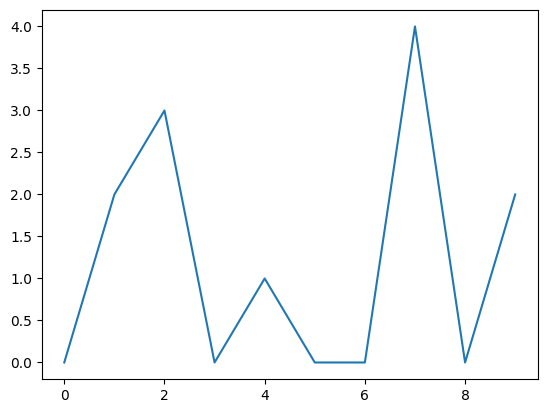

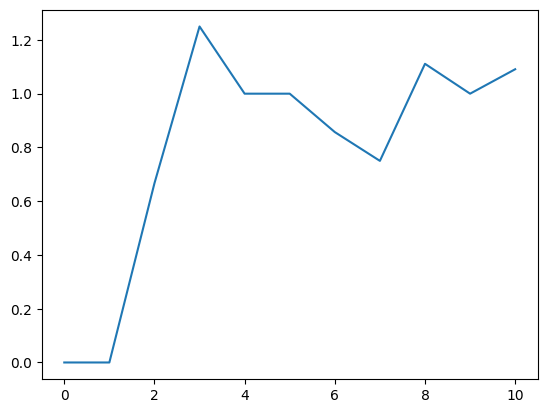

In [ ]:
env = gym.make('Breakout-v4')
print(env.observation_space.shape)
agent = better_dqn(env, env.observation_space.shape, env.action_space.n)
agent.epsilon = 0.01
agent.load('atari_dqn_new.h5')
epsilon_decay, reward_per_epi, avg_reward = agent.learn(10,100000)


# plt.plot(epsilon_decay)
# plt.show()

# plt.plot(reward_per_epi)
# plt.show()

# plt.plot(avg_reward)
# plt.show()